<a href="https://colab.research.google.com/github/OlajideFemi/GeneralContent/blob/master/ANN_coursework_Q1_Q3_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Artificial Neural Network Coursework — Solutions (Q1–Q3)







## Setup
Run this cell once.


In [9]:
import numpy as np
import matplotlib.pyplot as plt


# Question 1 — Multilayer Networks and EBP

## (a) Given `cloud.dat` (1000 two-dimensional vectors $r^T=(x,y)$), construct and train a neural network that models the probability density $\mathcal{P}(y\mid x)$. Report graphs of the parameters of your models vs $x$.

### Answer (Mixture Density Network / conditional mixture model)

We model the conditional density as a **mixture of two Gaussians** with parameters depending on $x$:

$$
\mathcal{P}(y\mid x)=\alpha_1(x)\,\mathcal{N}\!\big(y\mid \mu_1(x),\sigma_1^2(x)\big) +
\alpha_2(x)\,\mathcal{N}\!\big(y\mid \mu_2(x),\sigma_2^2(x)\big),
$$

with constraints $0<\alpha_1(x)<1$ and $\alpha_1(x)+\alpha_2(x)=1$. The Gaussian pdf is:

$$
\mathcal{N}(y\mid\mu,\sigma^2)=\frac{1}{\sqrt{2\pi\sigma^2}}\exp\!\left(-\frac{(y-\mu)^2}{2\sigma^2}\right).
$$

### Neural network parameterization
A feed-forward network takes input $x$ and outputs raw values $(a_1,a_2,m_1,m_2,s_1,s_2)$, transformed as:

- Mixture weights (softmax):  
$$
\alpha_k(x)=\frac{e^{a_k(x)}}{e^{a_1(x)}+e^{a_2(x)}}\quad (k=1,2)
$$
- Means (linear): $\mu_k(x)=m_k(x)$
- Standard deviations (softplus):  
$$
\sigma_k(x)=\log(1+e^{s_k(x)}) \quad \Rightarrow\quad \sigma_k^2(x)>0
$$

### Maximum likelihood training (NLL)
Given data $\{(x_n,y_n)\}_{n=1}^N$, we maximize conditional log-likelihood, equivalently minimize NLL:

$$
\mathrm{NLL}(\theta)=-\sum_{n=1}^{N}\log\left(\sum_{k=1}^{2}\alpha_k(x_n)\,
\mathcal{N}\!\big(y_n\mid\mu_k(x_n),\sigma_k^2(x_n)\big)\right).
$$

### What to report (plots)
After training, evaluate on a grid of $x$ values and plot versus $x$:

- $\alpha_1(x)$ and $\alpha_2(x)$  
- $\mu_1(x)$ and $\mu_2(x)$  
- $\sigma_1^2(x)$ and $\sigma_2^2(x)$


### Code (reference implementation)
Below is a minimal MDN implementation in **PyTorch**.


In [10]:
# (Optional) Install torch in Colab if needed:
# !pip -q install torch

import torch
import torch.nn as nn
import torch.nn.functional as F


In [11]:
# Load cloud.dat
# Expected format: 2 columns (x, y) with 1000 rows.
# In Colab: upload via the left sidebar (Files) or:
# from google.colab import files; files.upload()

import pandas as pd

fname = "cloud.dat"  # change if your file name differs

try:
    data = pd.read_csv(fname, header=None, delim_whitespace=True).values
except Exception:
    data = pd.read_csv(fname, header=None).values

x = data[:, 0:1].astype(np.float32)
y = data[:, 1:2].astype(np.float32)
print("Loaded:", data.shape)


Loaded: (1000, 2)


/tmp/ipython-input-3675085913.py:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(fname, header=None, delim_whitespace=True).values


In [12]:
# Train/val split
rng = np.random.default_rng(42)
idx = rng.permutation(len(x))
train_size = int(0.9 * len(x))
tr, va = idx[:train_size], idx[train_size:]

x_tr, y_tr = x[tr], y[tr]
x_va, y_va = x[va], y[va]

x_tr_t = torch.from_numpy(x_tr)
y_tr_t = torch.from_numpy(y_tr)
x_va_t = torch.from_numpy(x_va)
y_va_t = torch.from_numpy(y_va)


In [13]:
class MDN2(nn.Module):
    # Two-component 1D Gaussian MDN: returns alpha (N,2), mu (N,2), sigma (N,2).
    def __init__(self, hidden=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, hidden),
            nn.Tanh(),
            nn.Linear(hidden, hidden),
            nn.Tanh(),
        )
        self.out = nn.Linear(hidden, 6)  # a1,a2,m1,m2,s1,s2

    def forward(self, x):
        h = self.net(x)
        o = self.out(h)
        a1, a2, m1, m2, s1, s2 = torch.split(o, 1, dim=1)
        logits = torch.cat([a1, a2], dim=1)
        alpha = F.softmax(logits, dim=1)
        mu = torch.cat([m1, m2], dim=1)
        sigma = F.softplus(torch.cat([s1, s2], dim=1)) + 1e-6
        return alpha, mu, sigma

def mdn_nll(alpha, mu, sigma, y):
    y2 = y.expand(-1, 2)
    normal = torch.distributions.Normal(mu, sigma)
    log_prob = normal.log_prob(y2)           # (N,2)
    log_alpha = torch.log(alpha + 1e-12)     # (N,2)
    log_mix = torch.logsumexp(log_alpha + log_prob, dim=1)  # (N,)
    return -log_mix.mean()

model = MDN2(hidden=64)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(2000):
    model.train()
    alpha, mu, sigma = model(x_tr_t)
    loss = mdn_nll(alpha, mu, sigma, y_tr_t)

    opt.zero_grad()
    loss.backward()
    opt.step()

    if (epoch + 1) % 200 == 0:
        model.eval()
        with torch.no_grad():
            a_va, m_va, s_va = model(x_va_t)
            val_loss = mdn_nll(a_va, m_va, s_va, y_va_t).item()
        print(f"epoch {epoch+1:4d} | train NLL {loss.item():.4f} | val NLL {val_loss:.4f}")


epoch  200 | train NLL 0.1649 | val NLL 0.0492
epoch  400 | train NLL 0.1431 | val NLL 0.0346
epoch  600 | train NLL 0.1391 | val NLL 0.0295
epoch  800 | train NLL 0.1366 | val NLL 0.0308
epoch 1000 | train NLL 0.1340 | val NLL 0.0337
epoch 1200 | train NLL 0.1321 | val NLL 0.0353
epoch 1400 | train NLL 0.1305 | val NLL 0.0367
epoch 1600 | train NLL 0.1290 | val NLL 0.0381
epoch 1800 | train NLL 0.1277 | val NLL 0.0394
epoch 2000 | train NLL 0.1267 | val NLL 0.0408


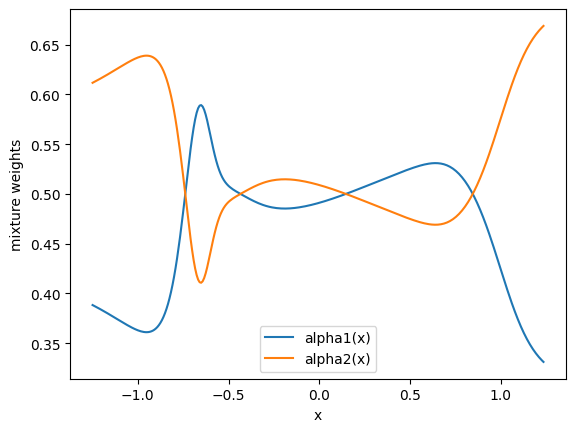

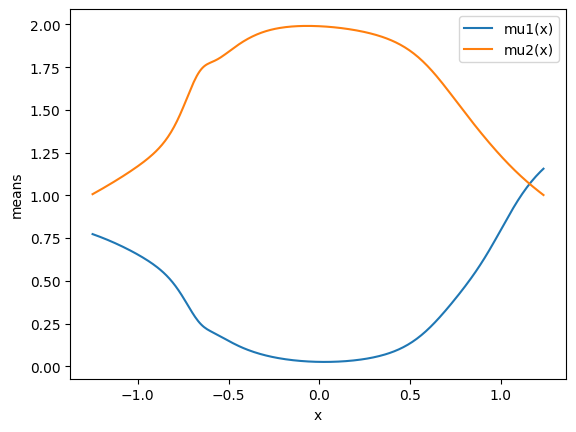

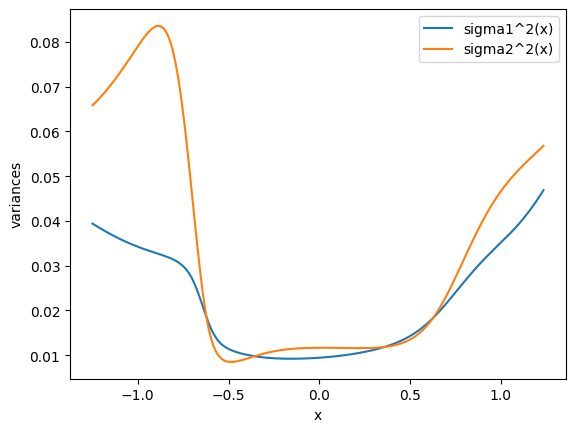

In [14]:
# Plot learned parameters vs x
model.eval()
x_grid = np.linspace(x.min(), x.max(), 300, dtype=np.float32).reshape(-1,1)
xg = torch.from_numpy(x_grid)

with torch.no_grad():
    alpha_g, mu_g, sigma_g = model(xg)

alpha_g = alpha_g.numpy()
mu_g = mu_g.numpy()
sig2_g = (sigma_g.numpy() ** 2)

plt.figure()
plt.plot(x_grid, alpha_g[:,0], label="alpha1(x)")
plt.plot(x_grid, alpha_g[:,1], label="alpha2(x)")
plt.xlabel("x"); plt.ylabel("mixture weights"); plt.legend(); plt.show()

plt.figure()
plt.plot(x_grid, mu_g[:,0], label="mu1(x)")
plt.plot(x_grid, mu_g[:,1], label="mu2(x)")
plt.xlabel("x"); plt.ylabel("means"); plt.legend(); plt.show()

plt.figure()
plt.plot(x_grid, sig2_g[:,0], label="sigma1^2(x)")
plt.plot(x_grid, sig2_g[:,1], label="sigma2^2(x)")
plt.xlabel("x"); plt.ylabel("variances"); plt.legend(); plt.show()


## (b) Use maximum likelihood to find $r_0$ and $\sigma^2$ in
$$
\mathcal{P}(r)=\frac{1}{2\pi}\frac{1}{\sqrt{2\pi\sigma^2}}
\exp\left(-\frac{(r-r_0)^2}{2\sigma^2}\right),
\quad r=\sqrt{x^2+(y-1)^2}.
$$

### Answer (MLE)

Given samples $r_1,\dots,r_N$, the constant factor $1/(2\pi)$ does not affect MLE. The log-likelihood (up to constants) is
$$
\ell(r_0,\sigma^2)= -\frac{N}{2}\log\sigma^2-\frac{1}{2\sigma^2}\sum_{n=1}^N (r_n-r_0)^2 + \text{const}.
$$

Setting derivatives to zero gives:

$$
\boxed{\hat r_0=\frac{1}{N}\sum_{n=1}^N r_n},
\qquad
\boxed{\widehat{\sigma^2}=\frac{1}{N}\sum_{n=1}^N (r_n-\hat r_0)^2}.
$$


In [15]:
# (Optional) Compute r0 and sigma^2 from cloud.dat if you loaded it above
r = np.sqrt(x[:,0]**2 + (y[:,0] - 1.0)**2)
r0_hat = r.mean()
sig2_hat = ((r - r0_hat)**2).mean()
r0_hat, sig2_hat


(np.float32(0.9997653), np.float32(0.009907177))

# Question 2 — Optimization (Entropy with constraints)

We consider the Shannon (functional) entropy:
$$
\mathcal{s}[p]\equiv -\int_0^\infty p(x)\log p(x)\,dx
$$
with constraints:
$$
\int_0^\infty p(x)\,dx=1,\qquad \int_0^\infty x\,p(x)\,dx=\mu,\quad \mu>0.
$$

> Important: the exponential distribution arises from **maximizing** entropy under these constraints.

## Answer (maximum entropy with fixed mean)

Define the Lagrangian functional:
$$
\mathcal{J}[p]=-\int_0^\infty p(x)\log p(x)\,dx
+\lambda_0\left(\int_0^\infty p(x)\,dx-1\right)
+\lambda_1\left(\int_0^\infty x\,p(x)\,dx-\mu\right).
$$

Using the functional derivative definition,
$$
\frac{\delta \mathcal{F}[p]}{\delta p(x_0)}=
\left.\frac{d}{d\lambda}\mathcal{F}[p(x)+\lambda\delta(x-x_0)]\right|_{\lambda=0},
$$
the stationarity condition $\delta\mathcal{J}/\delta p(x)=0$ gives
$$
-(\log p(x)+1)+\lambda_0+\lambda_1 x = 0
\;\Rightarrow\;
p(x)=C e^{\lambda_1 x}.
$$
Normalizability on $[0,\infty)$ requires $\lambda_1<0$. Writing $\lambda_1=-1/\mu$ and normalizing:
$$
1=\int_0^\infty C e^{-x/\mu}\,dx=C\mu\Rightarrow C=\frac{1}{\mu}.
$$
Therefore,
$$
\boxed{\mathcal{P}(x\mid\mu)=\frac{1}{\mu}e^{-x/\mu}},\qquad x\ge 0.
$$


# Question 3 — Radial Basis Function and Regularization

## (a) Gaussian basis diagonalization

Consider the 2D Gaussian basis function:
$$
\phi_j(\mathbf x)=\frac{1}{2\pi\sqrt{\det\Sigma}}
\exp\!\left(-\frac12(\mathbf x-\boldsymbol\mu_j)^\top\Sigma^{-1}(\mathbf x-\boldsymbol\mu_j)\right),
\qquad
\Sigma=\begin{pmatrix}2&-1\\-1&2\end{pmatrix}.
$$

### Answer

The eigenvalues of $\Sigma$ are $\lambda_1=1$ and $\lambda_2=3$ with orthonormal eigenvectors
$$
u_1=\frac{1}{\sqrt2}\begin{pmatrix}1\\1\end{pmatrix},\qquad
u_2=\frac{1}{\sqrt2}\begin{pmatrix}1\\-1\end{pmatrix}.
$$
Define the orthogonal rotation matrix and diagonal matrix:
$$
Q=\frac{1}{\sqrt2}\begin{pmatrix}1&1\\1&-1\end{pmatrix},\qquad
\Lambda=\begin{pmatrix}1&0\\0&3\end{pmatrix},
$$
so that
$$
\Sigma=Q^\top\Lambda Q,\qquad \Sigma^{-1}=Q^\top\Lambda^{-1}Q,\qquad
\Lambda^{-1}=\begin{pmatrix}1&0\\0&\tfrac13\end{pmatrix}.
$$

Introduce rotated coordinates:
$$
\begin{pmatrix}x'\\y'\end{pmatrix}=Q\begin{pmatrix}x\\y\end{pmatrix}
=\begin{pmatrix}\tfrac{x+y}{\sqrt2}\\[2pt]\tfrac{x-y}{\sqrt2}\end{pmatrix},
\qquad
\begin{pmatrix}\mu'_{xj}\\\mu'_{yj}\end{pmatrix}=Q\begin{pmatrix}\mu_{xj}\\\mu_{yj}\end{pmatrix}
=\begin{pmatrix}\tfrac{\mu_{xj}+\mu_{yj}}{\sqrt2}\\[2pt]\tfrac{\mu_{xj}-\mu_{yj}}{\sqrt2}\end{pmatrix}.
$$
Let $\mathbf z=\mathbf x-\boldsymbol\mu_j$ and $\mathbf z'=Q\mathbf z$. Then
$$
\mathbf z^\top\Sigma^{-1}\mathbf z = (\mathbf z')^\top\Lambda^{-1}\mathbf z'
= (x'-\mu'_{xj})^2 + \frac{(y'-\mu'_{yj})^2}{3}.
$$
Hence the exponent separates:
$$
-\frac12\mathbf z^\top\Sigma^{-1}\mathbf z
= -\frac{(x'-\mu'_{xj})^2}{2}-\frac{(y'-\mu'_{yj})^2}{6}.
$$
Also $\det\Sigma=\lambda_1\lambda_2=3$, so
$$
\frac{1}{2\pi\sqrt{\det\Sigma}}=\frac{1}{2\pi\sqrt3}
=\frac{1}{\sqrt{2\pi}}\cdot\frac{1}{\sqrt{6\pi}}.
$$
Therefore,
$$
\boxed{
\phi_j(\mathbf x)=
\frac{1}{\sqrt{2\pi}}e^{-(x'-\mu'_{xj})^2/2}\cdot
\frac{1}{\sqrt{6\pi}}e^{-(y'-\mu'_{yj})^2/6}
}.
$$

### Useful derivative
For
$$
g_j(\mathbf x)=-\frac12(\mathbf x-\boldsymbol\mu_j)^\top\Sigma^{-1}(\mathbf x-\boldsymbol\mu_j),
$$
since $\Sigma^{-1}$ is symmetric,
$$
\boxed{\nabla_{\mathbf x}g_j(\mathbf x)=-\Sigma^{-1}(\mathbf x-\boldsymbol\mu_j).}
$$
If $\phi_j(\mathbf x)=C e^{g_j(\mathbf x)}$, then
$$
\boxed{\nabla_{\mathbf x}\phi_j(\mathbf x)=-\phi_j(\mathbf x)\Sigma^{-1}(\mathbf x-\boldsymbol\mu_j).}
$$


## (b) Implement an RBF network with Gaussian kernels ($\sigma^2=0.1$) that interpolates Table 1

We use the 1D RBF model
$$
\hat y(x)=\sum_{j=1}^{N} w_j \exp\!\left(-\frac{(x-x_j)^2}{2\sigma^2}\right),\qquad \sigma^2=0.1,
$$
with centers at the data points. Define the design matrix:
$$
\Phi_{nj}=\exp\!\left(-\frac{(x_n-x_j)^2}{2\sigma^2}\right).
$$
Interpolation is achieved by solving
$$
\Phi\mathbf w=\mathbf y.
$$
If numerical instability occurs, use ridge regularization:
$$
\mathbf w_\lambda=(\Phi^\top\Phi+\lambda I)^{-1}\Phi^\top\mathbf y,\quad \lambda>0.
$$


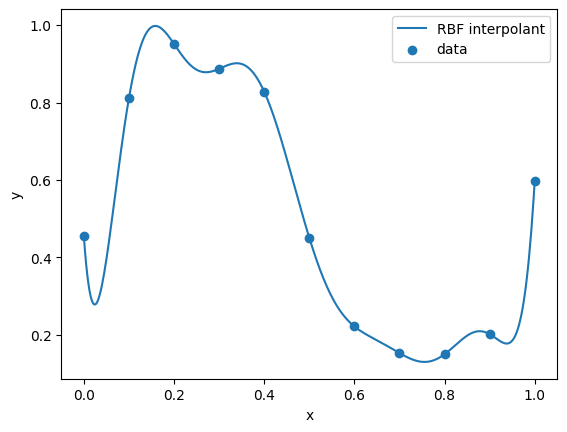

array([   239306.15620221,  -1589573.80139162,   5187058.64398028,
       -10950346.48230065,  16563145.65992782, -18758094.68437602,
        16111206.4197564 , -10364577.8935271 ,   4780619.95846351,
        -1427979.29100963,    209815.88279111])

In [16]:
# RBF interpolation for Table 1
x_data = np.array([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0], dtype=float)
y_data = np.array([0.4556,0.8110,0.9515,0.8871,0.8281,0.4509,0.2219,0.1530,0.1501,0.2019,0.5981], dtype=float)

sig2 = 0.1
N = len(x_data)
Phi = np.exp(-(x_data[:,None] - x_data[None,:])**2 / (2*sig2))
w = np.linalg.solve(Phi, y_data)

xg = np.linspace(0, 1, 400)
Phig = np.exp(-(xg[:,None] - x_data[None,:])**2 / (2*sig2))
yhat = Phig @ w

plt.figure()
plt.plot(xg, yhat, label="RBF interpolant")
plt.scatter(x_data, y_data, label="data")
plt.xlabel("x"); plt.ylabel("y"); plt.legend(); plt.show()

w
